# MSDS 7331 - Lab 1 - Baseball (Lehmans's Dataset)
***
Team - Triston Hudgins, Shijo Joseph, Douglas Yip

In [1]:
## Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import scatter
import plotly
from plotly.graph_objs import Scatter, Marker, Layout, layout,XAxis, YAxis, Bar, Line
%matplotlib inline

***
### Business Understanding (10 points total). Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? How would you measure the effectiveness of a good prediction algorithm? Be specific

The reason why we selected Lehman's baseball dataset is to understand the difficult decision a Major League Baseball (MLB) General Manager (GM) has to field a competitive team of talent while balancing that the fall below the team's salary cap.  Salary caps in baseball are placed to reduce anti-competitive behavior in the league.  This creates guardrails and fairness on how contracts are offered to players.  Teams that chose to spend more than the salary cap are penalized with "Competitive Balance Tax" (CBT).  Teams are asses a 20% tax for their first season above the salary cap and tax rate become more punitive for every consective year above the salary cap.

The performance of a player are usually rewarded contracts of varying degrees.  In this analysis, we will see how a players offensive stats can predict the outcome of player's salary.  We will categorize the salaries from Low to Elite to measure the effectives of our prediction model. Test!!!!

> Sources
> - http://origin.mlb.com/glossary/transactions/competitive-balance-tax
> - https://bleacherreport.com/articles/32306-open-mic-why-baseball-gms-have-the-most-difficult-job
***

##### Loading the data sets Player offensive stats and salaries.

In [80]:
# load the Lehman's baseball Batting dataset
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/dk28yip/MSDS7331_lab1/main/Batting.csv') # read in the csv file
df = df[(df['yearID'] >= 2000) & (df['yearID'] <= 2015)]
df.head()


,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
79265,abbotje01,2000,1,CHA,AL,80,215,31,59,15,...,29.0,2.0,1.0,21,38.0,1.0,2.0,2.0,1.0,2.0
79266,abbotku01,2000,1,NYN,NL,79,157,22,34,7,...,12.0,1.0,1.0,14,51.0,2.0,1.0,0.0,1.0,2.0
79267,abbotpa01,2000,1,SEA,AL,35,5,1,2,1,...,0.0,0.0,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0
79268,abreubo01,2000,1,PHI,NL,154,576,103,182,42,...,79.0,28.0,8.0,100,116.0,9.0,1.0,0.0,3.0,12.0
79269,aceveju01,2000,1,MIL,NL,62,1,1,0,0,...,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# load the Lehman's baseball salary dataset

df_salary = pd.read_csv('https://raw.githubusercontent.com/dk28yip/MSDS7331_lab1/main/Salaries.csv') # read in the csv file
df_salary = df_salary[(df_salary['yearID'] >= 2000) & (df_salary['yearID'] <= 2015)]
df_salary.head()

,yearID,teamID,lgID,playerID,salary
12263,2000,ANA,AL,anderga01,3250000
12264,2000,ANA,AL,belchti01,4600000
12265,2000,ANA,AL,botteke01,4000000
12266,2000,ANA,AL,clemeed02,215000
12267,2000,ANA,AL,colanmi01,200000


Merging of the data sets will help us get a better picture of a players salary and their baseball stats

In [82]:
df = pd.merge(df,df_salary[['playerID','yearID','teamID','salary']],on=['playerID','yearID','teamID'], how='left')
df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,salary
0,abbotje01,2000,1,CHA,AL,80,215,31,59,15,...,2.0,1.0,21,38.0,1.0,2.0,2.0,1.0,2.0,255000.0
1,abbotku01,2000,1,NYN,NL,79,157,22,34,7,...,1.0,1.0,14,51.0,2.0,1.0,0.0,1.0,2.0,500000.0
2,abbotpa01,2000,1,SEA,AL,35,5,1,2,1,...,0.0,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,285000.0
3,abreubo01,2000,1,PHI,NL,154,576,103,182,42,...,28.0,8.0,100,116.0,9.0,1.0,0.0,3.0,12.0,2933333.0
4,aceveju01,2000,1,MIL,NL,62,1,1,0,0,...,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,612500.0


***
### [10 points] Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.

In [83]:
#following code will describe the data
df.describe()

,yearID,stint,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,salary
count,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,22083.000000,1.284700e+04
mean,2007.608251,1.086854,50.089888,120.486302,16.074718,31.480822,6.287778,0.656478,3.622832,15.303446,2.055291,0.825341,11.353892,24.252276,0.889236,1.219309,1.123625,0.971109,2.738532,3.073175e+06
std,4.632573,0.297273,45.772948,180.721109,26.868157,50.531427,10.524455,1.582814,7.451858,26.456559,5.786324,1.977861,20.081184,35.650176,2.697024,2.641271,2.326378,1.890580,4.750978,4.181921e+06
min,2000.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.655740e+05
25%,2004.000000,1.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.293000e+05
50%,2008.000000,1.000000,33.000000,18.000000,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.015000e+06
75%,2012.000000,1.000000,73.000000,178.000000,21.000000,44.000000,8.000000,1.000000,3.000000,19.000000,1.000000,1.000000,14.000000,36.000000,0.000000,1.000000,1.000000,1.000000,4.000000,4.000000e+06
max,2015.000000,4.000000,163.000000,716.000000,152.000000,262.000000,59.000000,23.000000,73.000000,160.000000,78.000000,24.000000,232.000000,223.000000,120.000000,30.000000,24.000000,16.000000,32.000000,3.300000e+07


In [43]:
print (df.dtypes)
print (df.info())

playerID     object
yearID        int64
stint         int64
teamID       object
lgID         object
G             int64
AB            int64
R             int64
H             int64
2B            int64
3B            int64
HR            int64
RBI         float64
SB          float64
CS          float64
BB            int64
SO          float64
IBB         float64
HBP         float64
SH          float64
SF          float64
GIDP        float64
salary      float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31230 entries, 0 to 31229
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerID  31230 non-null  object 
 1   yearID    31230 non-null  int64  
 2   stint     31230 non-null  int64  
 3   teamID    31230 non-null  object 
 4   lgID      31230 non-null  object 
 5   G         31230 non-null  int64  
 6   AB        31230 non-null  int64  
 7   R         31230 non-null  int64  
 8   H         31230 non-nu

#### Summary of values
A total of 1486 offsensive players were recorded in the dataset for 2015.
The following full season statistics (columns of continous variables) will be used
 - __G:__- Games played
 - __AB:__- Number of plate apearances
 - __R:__- Number of times a player scores
 - __H:__- Number of hits
 - __2B:__- Number of doubles
 - __3B:__- Number of triples
 - __HR:__- Number of home runs
 - __RBI:__- Number of Runs Batted In
 - __SB:__- Number of stolen bases 
 - __CS:__- Number of times caught stealing
 - __BB:__- Number of base on balls (walks)
 - __SO:__- Number of strike outs
 - __IBB:__- Number of intentional base on balls (walks)
 - __HBP:__- Number of times hit by pitch
 - __SH:__- Number of sacrifice hits.  Recorded when player is able to advance the runner
 - __SB:__- Number of sacrifice bunts.  Recorded when player is able to advance the runner
 - __SF:__- Number of sacrifice fly.  Recorded when player is able to advance the runner and run scores
 - __GIDP:__- Number of Grounded in Double Play.  Recorded when player inability to hit that results into two outs.
 - __Salary:__- Players earnings in the season
 
 Categorical Varialbes definition butwill not be used in analysis
 - __playerID:__- Unique Identifier of player
 - __teamID:__- Unique Identifier of team
 - __lgID:__- Unique Identifier which league they play in

In [84]:
display(df.shape)

(22083, 23)

The dataset has 1486 rows and 23 columns

***
### [15 points] Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Be specific.

In [85]:
#check for NA
df.isnull().sum()

playerID       0
yearID         0
stint          0
teamID         0
lgID           0
G              0
AB             0
R              0
H              0
2B             0
3B             0
HR             0
RBI            0
SB             0
CS             0
BB             0
SO             0
IBB            0
HBP            0
SH             0
SF             0
GIDP           0
salary      9236
dtype: int64

Salaries are null for 9236 records.

In [86]:
# Any missing values in the dataset
def plot_missingness(df: pd.DataFrame=df) -> None:
    nan_df = pd.DataFrame(df.isna().sum()).reset_index()
    nan_df.columns  = ['Column', 'NaN_Count']
    nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
    nan_df['NaN_%'] = round(nan_df['NaN_Count']/df.shape[0] * 100,1)
    nan_df['Type']  = 'Missingness'
    nan_df.sort_values('NaN_%', inplace=True)

    # Add completeness
    for i in range(nan_df.shape[0]):
        complete_df = pd.DataFrame([nan_df.loc[i,'Column'],df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
        complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
        complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
        complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
        nan_df = pd.concat([nan_df,complete_df], sort=True)
            
    nan_df = nan_df.rename(columns={"Column": "Feature", "NaN_%": "Missing %"})

    # Missingness Plot
    fig = px.bar(nan_df,
                 x='Feature',
                 y='Missing %',
                 title=f"Missingness Plot (N={df.shape[0]})",
                 color='Type',
                 template='plotly_dark',
                 opacity = 0.6,
                 color_discrete_sequence=['#dbdbdb','#38cae0'],
                 width=800,
                 height=400)
    fig.show()

plot_missingness(df)

We want to see what type of players don't have salary details.

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,salary
8,alcanis01,2000,1,BOS,AL,21,45,9,13,1,...,0.0,0.0,3,7.0,0.0,0.0,0.0,0.0,0.0,NaN
14,allench01,2000,1,MIN,AL,15,50,2,15,3,...,0.0,2.0,3,14.0,0.0,1.0,0.0,1.0,1.0,NaN
15,allendu01,2000,1,SDN,NL,9,12,0,0,0,...,0.0,0.0,2,5.0,0.0,0.0,0.0,0.0,1.0,NaN
16,allendu01,2000,2,DET,AL,18,16,5,7,2,...,0.0,0.0,2,7.0,0.0,0.0,0.0,0.0,0.0,NaN
22,alvarcl01,2000,1,PHI,NL,2,5,1,1,0,...,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22069,ynoara01,2015,1,COL,NL,72,127,14,33,8,...,1.0,0.0,3,28.0,0.0,0.0,1.0,0.0,2.0,NaN
22074,younger03,2015,2,NYN,NL,18,8,9,0,0,...,3.0,2.0,0,1.0,0.0,1.0,0.0,0.0,0.0,NaN
22078,zitoba01,2015,1,OAK,AL,3,0,0,0,0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
22080,zobribe01,2015,2,KCA,AL,59,232,37,66,16,...,2.0,3.0,29,30.0,1.0,1.0,0.0,2.0,3.0,NaN


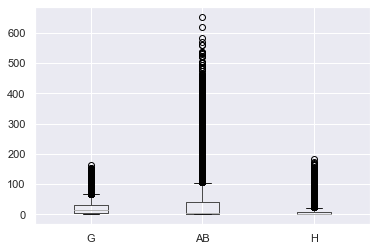

In [87]:
null_data = df[df.isnull().any(axis=1)]
display(null_data)

ax = null_data.boxplot(column=['G', 'AB','H'])
#ax.set_yscale('log')

Based on the box 75% of the Players with no salary have played less than 75 games or has less than 75 at bats or 10 hits.  Although the rest may have significant playing time, we cannot imput the data since the salary of contracts must be manually inputted.  As a result of this project, we will remove the rows.  

#### Removing the rows with missing values

In [88]:
print("Number of Rows before removing:", len(df))
df_clean = df.dropna()
print("Total number of rows after removing the rows with missing values:",len(df_clean))

Number of Rows before removing: 22083
Total number of rows after removing the rows with missing values: 12847


***
### [5 points] Are there other features that could be added to the data or created from existing features? Which ones?

#### For prediction purposes, we have categorized salary and grouped players salaries based on the salary range (Low - below 50%, Medium - 50%-75%, High-+75%, Elite)
> - Low (0-1,999,999)
> - Medium (2-5,999,999)
> - High (6,000,000 - 14,999,999)
> - Elite (+15,000,000)

In [89]:
df_clean['salary_cut'] = pd.cut(df_clean['salary'], bins = [0,1999999,5999999,14999999,50000000], labels=["Low", "Medium", "High", "Elite"], right=True)
df_clean.head()

C:\Users\Shijo\AppData\Local\Temp\ipykernel_89592\3717145528.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,CS,BB,SO,IBB,HBP,SH,SF,GIDP,salary,salary_cut
0,abbotje01,2000,1,CHA,AL,80,215,31,59,15,...,1.0,21,38.0,1.0,2.0,2.0,1.0,2.0,255000.0,Low
1,abbotku01,2000,1,NYN,NL,79,157,22,34,7,...,1.0,14,51.0,2.0,1.0,0.0,1.0,2.0,500000.0,Low
2,abbotpa01,2000,1,SEA,AL,35,5,1,2,1,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,285000.0,Low
3,abreubo01,2000,1,PHI,NL,154,576,103,182,42,...,8.0,100,116.0,9.0,1.0,0.0,3.0,12.0,2933333.0,Medium
4,aceveju01,2000,1,MIL,NL,62,1,1,0,0,...,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,612500.0,Low


#### Two other metrics can be derived from this 
> - On Base Percentage (OBP), quantity of getting on base per at bat
> - Slugging Percentage (SLG), quality of hits per at bat

In [90]:
#add new columns
df_clean["OBP"] = np.where((df_clean["AB"] +  df_clean["IBB"] + df_clean["BB"] + df_clean["HBP"] + df_clean["SF"]) !=0, 
                           (df_clean["H"] +  df_clean["IBB"] + df_clean["BB"] + df_clean["HBP"])/(df_clean["AB"] +  df_clean["IBB"] + df_clean["BB"] + df_clean["HBP"] + df_clean["SF"]),
                            0)
df_clean["SLG"] = np.where(df_clean["AB"] !=0,
                           (df_clean["H"] + df_clean["2B"]*2 + df_clean["3B"]*3 + df_clean["HR"]*4)/df_clean["AB"],
                           0)
df_clean.head()

C:\Users\Shijo\AppData\Local\Temp\ipykernel_89592\4269024106.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Shijo\AppData\Local\Temp\ipykernel_89592\4269024106.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,SO,IBB,HBP,SH,SF,GIDP,salary,salary_cut,OBP,SLG
0,abbotje01,2000,1,CHA,AL,80,215,31,59,15,...,38.0,1.0,2.0,2.0,1.0,2.0,255000.0,Low,0.345833,0.483721
1,abbotku01,2000,1,NYN,NL,79,157,22,34,7,...,51.0,2.0,1.0,0.0,1.0,2.0,500000.0,Low,0.291429,0.477707
2,abbotpa01,2000,1,SEA,AL,35,5,1,2,1,...,1.0,0.0,0.0,1.0,0.0,0.0,285000.0,Low,0.400000,0.800000
3,abreubo01,2000,1,PHI,NL,154,576,103,182,42,...,116.0,9.0,1.0,0.0,3.0,12.0,2933333.0,Medium,0.423803,0.687500
4,aceveju01,2000,1,MIL,NL,62,1,1,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,612500.0,Low,0.500000,0.000000


In [91]:
df_clean.max()

playerID       zuninmi01
yearID              2015
stint                  4
teamID               WAS
lgID                  NL
G                    163
AB                   716
R                    152
H                    262
2B                    59
3B                    23
HR                    73
RBI                160.0
SB                  78.0
CS                  24.0
BB                   232
SO                 223.0
IBB                120.0
HBP                 30.0
SH                  24.0
SF                  16.0
GIDP                32.0
salary        33000000.0
salary_cut         Elite
OBP                  1.0
SLG                  5.0
dtype: object

***
### [15 points] Visualize the most important attributes appropriately (at least 5 attributes). Important: Provide an interpretation for each chart. Explain for each attribute why the chosen visualization is appropriate.

[Text(0.5, 1.0, 'OBP by Salary Cut')]

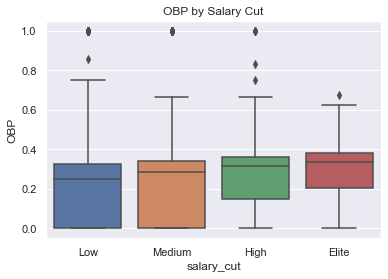

In [92]:
## OBP by salary cut
sns.boxplot(x="salary_cut", y="OBP", data=df_clean).set(title = 'OBP by Salary Cut')


[Text(0.5, 1.0, 'SLG by Salary Cut')]

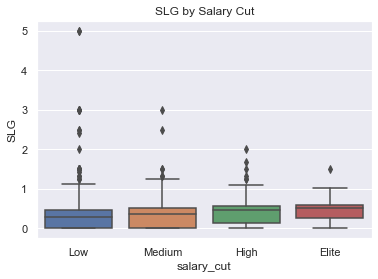

In [93]:
## SLG by salary cut
sns.boxplot(x="salary_cut", y="SLG", data=df_clean).set(title = 'SLG by Salary Cut')


[Text(0.5, 1.0, 'Salary by Salary Cut')]

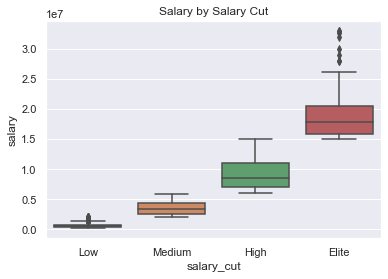

In [94]:
## salary ranges by salary cut
sns.boxplot(x="salary_cut", y="salary", data=df_clean).set(title = 'Salary by Salary Cut')


<AxesSubplot:xlabel='salary', ylabel='OBP'>

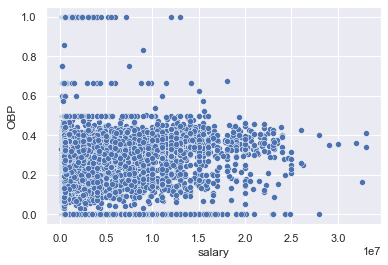

In [95]:
## scatterplot ranges by salary cut
sns.scatterplot(x="salary", y="OBP", data=df_clean)

<AxesSubplot:xlabel='salary', ylabel='SLG'>

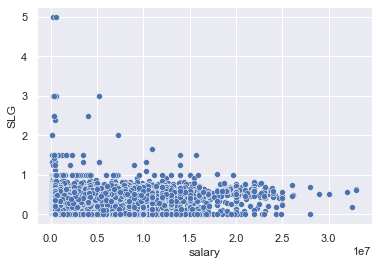

In [96]:
## scatterplot ranges by salary cut
sns.scatterplot(x="salary", y="SLG", data=df_clean)

***
### [15 points] Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.

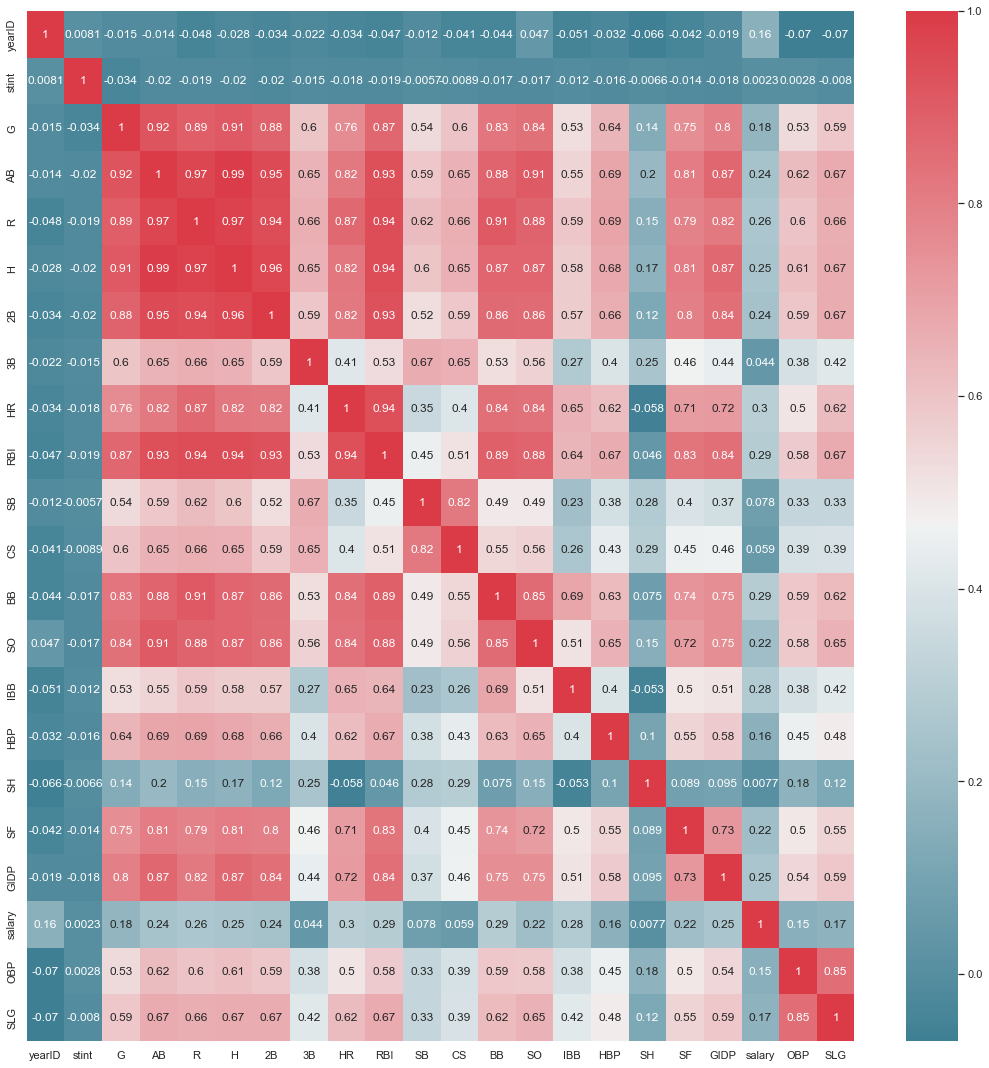

In [72]:
# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
f, ax = plt.subplots(figsize=(15, 15))

#df_clean2 = df_clean.loc[:,~df_clean.columns.isin(['AB', 'G'])]
#sns.heatmap(df_clean2.corr(), cmap=cmap, annot=True)
sns.heatmap(df_clean.corr(), cmap=cmap, annot=True)
f.tight_layout()

In [ ]:
sns.pairplot(df_clean, hue="salary_cut", height=2)

***
### [10 points] Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).

In [ ]:
## needs to be completed

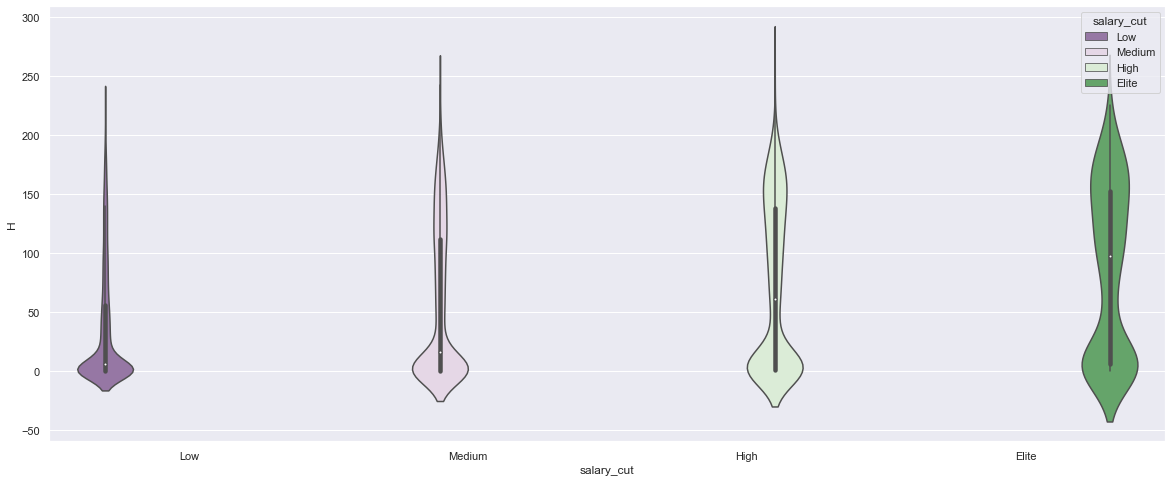

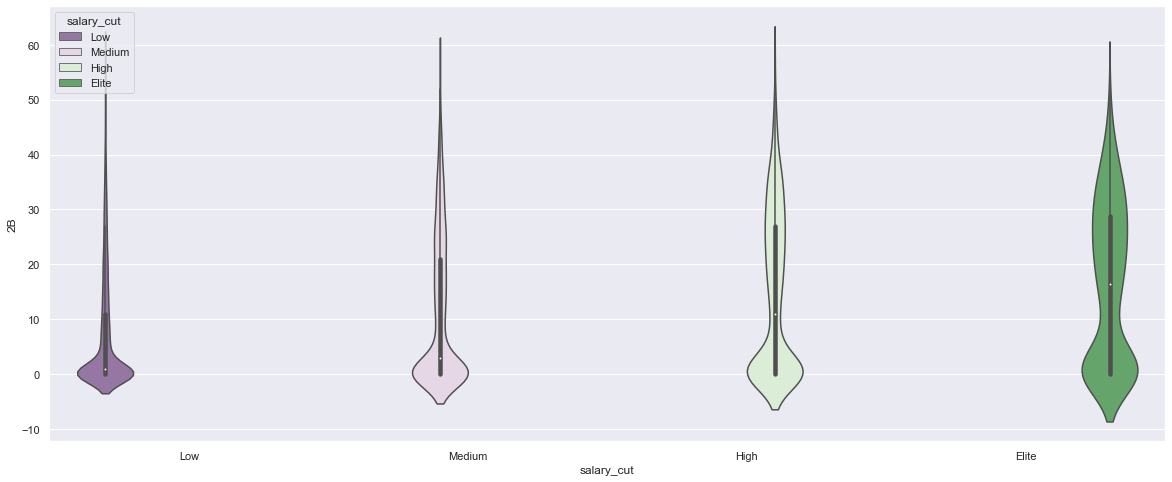

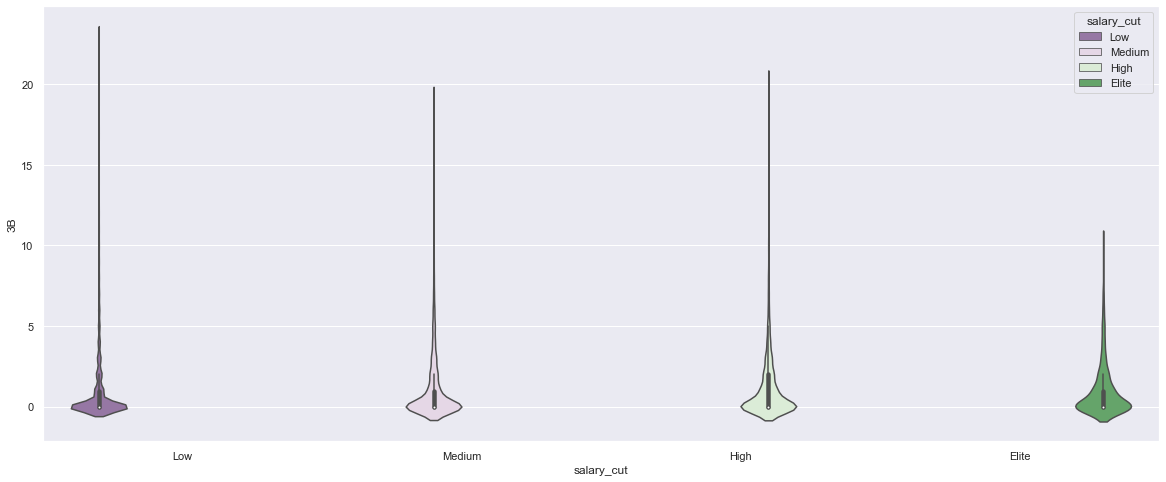

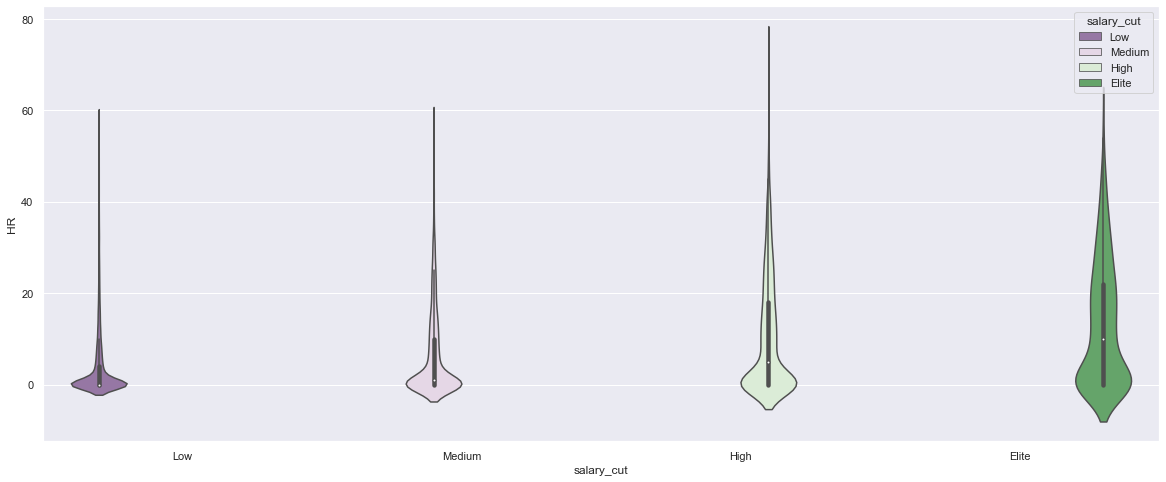

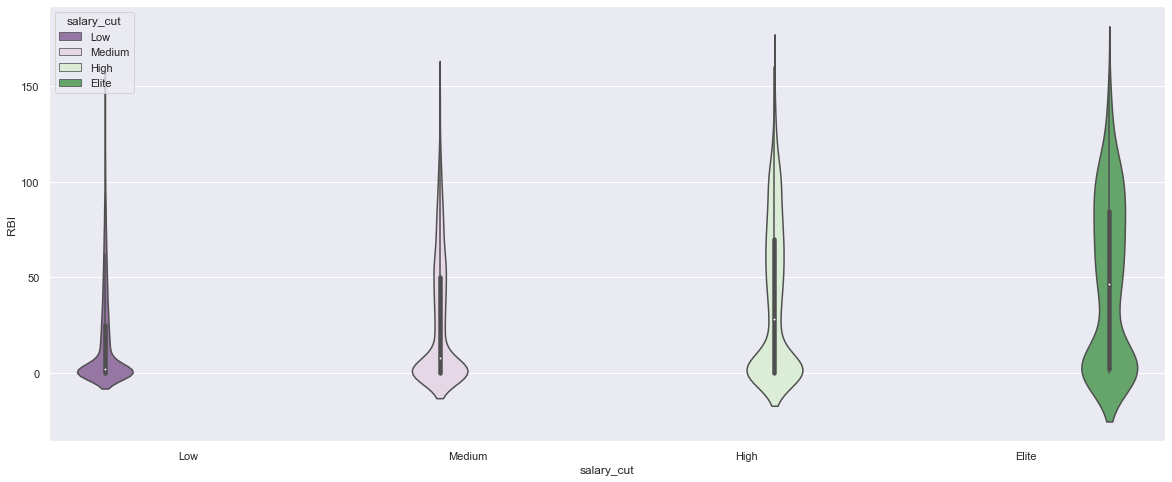

In [58]:
column = ['H', '2B', '3B', 'HR', 'RBI']
for col in column:
    plt.subplots(figsize=(20, 8))
    sns.violinplot(x="salary_cut", hue="salary_cut", y=col, data=df_clean,
            kind='violin', # other options: violin, bar, box, and others 
               palette='PRGn',
               height=7,ci=95)

***
### [10 points] Exceptional Work

In [ ]:
You have free reign to provide additional analyses.
One idea: implement dimensionality reduction, then visualize and interpret the results.

In [59]:
# Use PCA from sklearn.decomposition
pca = PCA(n_components=2)
lda = LDA(n_components=2)
# Fit data and transform it
pca.fit(X)
X_pca = pca.transform(X)
X_lda = lda.fit(X, Y).transform(X)

NameError: name 'X' is not defined

In [ ]:
print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)